# Data science tools for model selection and evaluation

Data is available in unprecedented amounts, and the field "Data Science" has been cobbled together from statistics, computer science, physics, and many more. Increasingly, the analysis capability is also increasing, and it is being made available to anyone with a laptop, through open source initiatives e.g. within the Python ecosystem. This is a very exciting development for Earth Sceince as a field, but should be applied with care and robustness of applications validated as far as possible.

In this hands-on tutorial, we will explore concepts related to "unsupervised" machine learning. We will explore structures within synthetic data we generate, so we know the answers we want the "machine" to find! The lecture is outlined as follows:

1. K-means as an unsupervised data exploration tool
2. Using Information Criteria to inform parameter choices 
3. Appreciating and accounting for underlying assumptions


## By the end of this tutorial you should be able to:
- Apply k-means to data, varying the number of parameters 'k'
- Assess the fit of the chosen k-means model using information criteria
- Understand what changing parameters does for k-means models
- Appreciate the importance of critical model evaluation


For a more in-depth plunge and additional reading:

- Annalyn Ng's "Numsense! Data Science for the Layman: No Math Added"

- Joel Grus' "Data Science from Scratch: First Principles with Python"



## 1. K-means as an unsupervised data exploration tool


Unsupervised learning techniques are a great way to explore data, even if you may not know the underlying structure. There are many algorithms available, and here we use k-means as our exploratory tool. 

### K-means assumptions to be aware of:

With every clustering algorithm come assumptions about the data. These "assumptions" refer to the structures within how different variables within a data set interract with one another. These interactions produce different "shapes". For data that are "round" (also refered to as "Gaussian"), k-means is a good starting point.

The k-means algorithm is based on underlying mathematics that allows it to partition the area and identify clusters$^1$. The way it does this is by effectively drawing "straight lines" (in examples here in 2D). It follows that any structures that k-means can't be seperate using straight lines would mean that the results would be poor. This effectively means that k-means would only do a "perfect" job if our data were normally distributed; a very strong assumption.

To initialize, the k-means algorithm makes a stochastic guess. This means that points are initially scattered across the data, and the algorithm iterates until a "maximum" in found. This maximum is determined by minimuzimg the objective function J:

$$J = \sum^{k}_{j=1} \sum^{n}_{i=1} ||x^{j}_i - c_{j}||^2$$

where $k$ is the number of clusters, $n$ is the number of data points, $c$ is the place where the "guess" of the cluster location is.


1: Voroni diagrams if you happen to be a math major: http://nms.csail.mit.edu/~aklmiu/6.838/L7.pdf

In [33]:
# We start by loading some handy libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn import mixture
import seaborn as sns; sns.set()

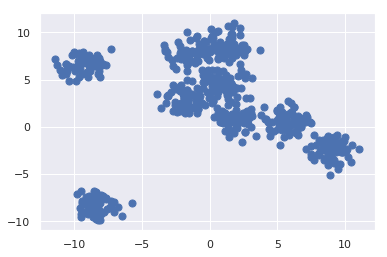

In [73]:
# Set the number of clusters that the algorithm should ideally find
centerSeed = 9

# Making the "blobs"
X, y_true = make_blobs(n_samples=600, centers=centerSeed,
                       cluster_std=0.9, random_state=0)
# Plot the data
plt.scatter(X[:, 0], X[:, 1], s=50);




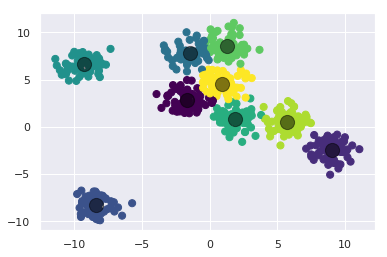

In [74]:
# Applying the clustering to 

kmeans = KMeans(n_clusters=centerSeed)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plotting the data again, but coloured by the clusters, and the centroids highlighted by the black point
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


At this point, pretend we know nothing of the above! The cluser data make_blobs helpfully created is unknown to us, and we want to explore it! 

We proceed by estimating the AIC and BIC to explore

Bonus points for anyone who recognizes similarities to the lecture plots...

## 2. Using Information Criteria to inform parameter choices 

Assessing if identified structures give us "useful" information is very important, and we can do this applying statistical tools.




In [75]:


repeats = 5 # Remember there is stochasticity involved, so de do 10 repeats to collect some error estimates.
kClusters = 15 # Going up to 40 as out "guess" takes time, but it can be worth it!
data = X

criteriaAIC_BIC = np.zeros((repeats,2,kClusters))
for rep in np.arange(0,repeats):
    for nr in np.arange(1,kClusters):
        n_clusters=nr
        X=data
        model=mixture.GaussianMixture(n_components=n_clusters, init_params='kmeans')
        model.fit(X)
        criteriaAIC_BIC[rep,0,nr]=model.aic(X)
        criteriaAIC_BIC[rep,1,nr]=model.bic(X)

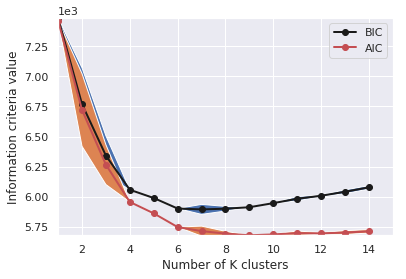

In [76]:
meanAIC = criteriaAIC_BIC[:, 0, 0:kClusters].mean(axis = 0)
stdAIC = criteriaAIC_BIC[:, 0, 0:kClusters].std(axis = 0)

meanBIC = criteriaAIC_BIC[:, 1, 0:kClusters].mean(axis = 0)
stdBIC = criteriaAIC_BIC[:, 1, 0:kClusters].std(axis = 0)

plt.plot(np.arange(0, kClusters),meanBIC, '-ok', label='BIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanBIC-2*stdBIC, meanBIC+2*stdBIC)

plt.plot(np.arange(0, kClusters),meanAIC, '-or', label='AIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanAIC-2*stdAIC, meanAIC+2*stdAIC)


plt.ylim(np.min(meanAIC[5:]), np.max(meanBIC))
plt.xlabel('Number of K clusters')
plt.ylabel('Information criteria value')
plt.legend()
plt.xlim(1,kClusters)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('informationCriteriaAsymptoting_wError.png', format='png', dpi=500, bbox_inches='tight')  

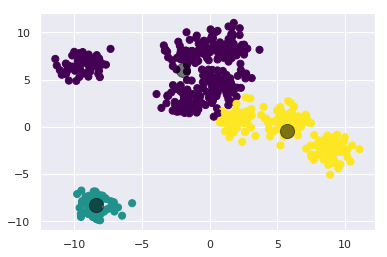

In [77]:
### Replace with your guess!
clusterGuess=3

kmeans = KMeans(n_clusters=clusterGuess)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);



## 3. Real-world applications require an appreciation of for underlying assumptions

Because we mostly have limited or no knowledge of the structures in our data, it is prudent to be aware of the assumptions our clustering methods make. We need to assess if these assumptions are fair. If we don't take assumptions into account, we may end up with useless or even misleading results!



## 3.1 What if the structures are not "round"?

Unfortunately, most data one encounters are not "round"/Gaussian. Below we'll demonstrate what happens when we have different data distributions, and explore how "wrong" k-means can be.

- Assessing how good the fit is using the AIC and BIC are a good way of assessing if this could be an issue.

## 3.2 What if the stocastic element makes a difference? 

To initialize k-means the algorithm makes a stochastic "guess" as the cluster centers. This means that if we repeat the method, the initial "guess" could be different enough to give us a different answer. 

- Assessing how good the fit is using the AIC and BIC are a good way of assessing if this could be an issue.

Text(0.5, 1.0, 'Anisotropicly Distributed Data')

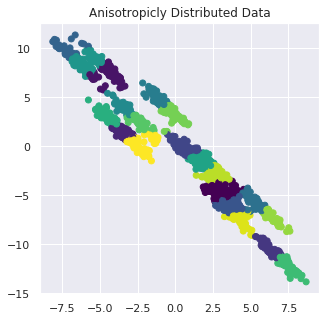

In [80]:
cluster_guess=20

plt.figure(figsize=(5, 5))
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=12)

#### Anisotropicly distributed data ####
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=cluster_guess, random_state=random_state).fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='viridis')
plt.title("Anisotropicly Distributed Data")



In [81]:
repeats = 5 # Remember there is stochasticity involved, so de do 10 repeats to collect some error estimates.
kClusters = 25 # Going up to a high "guess" takes time, but it can be worth it!
data = X_aniso

criteriaAIC_BIC = np.zeros((repeats,2,kClusters))
for rep in np.arange(0,repeats):
    for nr in np.arange(1,kClusters):
        n_clusters=nr
        #X=data
        model=mixture.GaussianMixture(n_components=n_clusters, init_params='kmeans')
        model.fit(data)
        criteriaAIC_BIC[rep,0,nr]=model.aic(data)
        criteriaAIC_BIC[rep,1,nr]=model.bic(data)

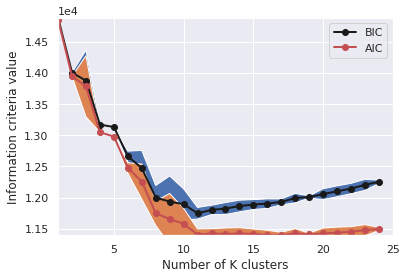

In [82]:
meanAIC = criteriaAIC_BIC[:, 0, 0:kClusters].mean(axis = 0)
stdAIC = criteriaAIC_BIC[:, 0, 0:kClusters].std(axis = 0)

meanBIC = criteriaAIC_BIC[:, 1, 0:kClusters].mean(axis = 0)
stdBIC = criteriaAIC_BIC[:, 1, 0:kClusters].std(axis = 0)

plt.plot(np.arange(0, kClusters),meanBIC, '-ok', label='BIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanBIC-2*stdBIC, meanBIC+2*stdBIC)

plt.plot(np.arange(0, kClusters),meanAIC, '-or', label='AIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanAIC-2*stdAIC, meanAIC+2*stdAIC)


plt.ylim(np.min(meanAIC[5:]), np.max(meanBIC))
plt.xlabel('Number of K clusters')
plt.ylabel('Information criteria value')
plt.legend()
plt.xlim(1,kClusters)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('informationCriteriaAsymptoting_wError.png', format='png', dpi=500, bbox_inches='tight')  

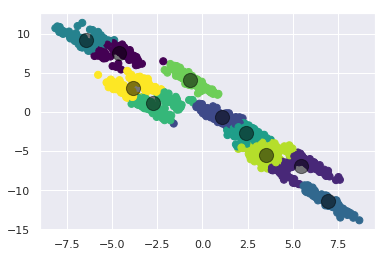

In [93]:
### Replace with your guess of choice
clusterGuess=10

kmeans = KMeans(n_clusters=clusterGuess)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)


plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


This tutorial is by Maike Sonnewald (github: maikejulie, maikejulie@gmail.com) but drew from Randy Olson (github: rhiever), and Phil Roth <mr.phil.roth@gmail.com>
(License: BSD 3 clause)